# IMPORT LIBRERIE E DATI

In [1]:
!pip install -q transformers datasets numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, TrainingArguments, Trainer, create_optimizer, AdamWeightDecay, DataCollatorForSeq2Seq
from transformers.keras_callbacks import PushToHubCallback
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import datasets
from datasets import Dataset
import os
from numba import cuda

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
#Function to read a list from a file
def read_list_from_file(filename):
  result = []
  # opening the file in read mode
  my_file = open(filename, "r")

  # reading the file
  data = my_file.read()

  # replacing end splitting the text
  # when newline ('\n') is seen.
  data_into_list = data.split("\n")
  my_file.close()

  return data_into_list

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Filename of the review list's file
filename_review_list = "drive/Shareddrives/BPM PROJECT/Dataset/review_list.txt"

#Filename of the dataset
filename_dataset = "drive/Shareddrives/BPM PROJECT/Dataset/amazon_reviews_reduced.csv"

In [6]:
amazon_reviews = pd.read_csv(filename_dataset, on_bad_lines="skip")

In [7]:
amazon_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54418 entries, 0 to 54417
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         54418 non-null  int64 
 1   marketplace        54418 non-null  object
 2   customer_id        54418 non-null  int64 
 3   review_id          54418 non-null  object
 4   product_id         54418 non-null  object
 5   product_parent     54418 non-null  int64 
 6   product_title      54418 non-null  object
 7   product_category   54418 non-null  object
 8   star_rating        54418 non-null  int64 
 9   helpful_votes      54418 non-null  int64 
 10  total_votes        54418 non-null  int64 
 11  vine               54418 non-null  object
 12  verified_purchase  54418 non-null  object
 13  review_headline    54417 non-null  object
 14  review_body        54416 non-null  object
 15  review_date        54418 non-null  object
dtypes: int64(6), object(10)
memory usage: 6.

# DEFINIZIONE FUNZIONI

In [8]:
def get_dataset_from_product_id(df, product_id, number_of_samples, test_size, shuffle):
  csv_r = df[df["product_id"] == product_id]
  csv_r = csv_r[["review_body", "review_headline"]]
  csv_r = csv_r[~csv_r["review_headline"].isin(["Five Stars", "Four Stars", "Three Stars", "Two Stars", "One Star"])]

  #TODO
  # review_body and review_headline must be preprocessed

  dataset = Dataset.from_pandas(df = csv_r.sample(number_of_samples))
  dataset = dataset.train_test_split(test_size = test_size)

  return dataset

In [9]:
prefix = "summarize: "

def preprocess_function(examples):
    # inputs = [prefix + doc for doc in examples["review_body"]]
    inputs = [doc for doc in examples["review_body"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)

    labels = tokenizer(text_target=examples["review_headline"], max_length=256, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [10]:
def plot_training_history(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  i = np.argmin(val_loss)
  x_min = epochs[i]
  y_min = val_loss[i]
  plt.plot(x_min, y_min,'g',marker='o', label="Minimum validation loss")

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [11]:
def get_batches(reviews, sample):

  input = "summarize:"
  count = 0
  checkpoint = 0


  #batch creation
  #creo un array di testi concatenati, ognuno dei quali ha massimo 1024 token
  #lo stesso procedimento verrà fatto con i riassunti generati!
  # si parte da checkpoint in poi, fino a finire il ciclo.

  batches = []
  i = 0

  if sample:
    num_samples = 100
  else:
    num_samples = len(reviews)

  for i in range(0,num_samples):
  # for i in range(0,43):
    if count + len(reviews[i].split(" ")) < 1024:
      #print(cleaned_reviews[i])
      input = input + reviews[i] + " . "
      #print(input)
      count = count + len(reviews[i].split(" "))
    else:
      batches.append(input)
      print('Input {} created with a length of {} tokens.'.format(len(batches), count))
      print("Number of reviews processed: {}".format(i))
      input = "summarize: " + reviews[i] + " . "
      count = len(reviews[i].split(" "))

  if(count != 0):
    batches.append(input)
    print('Input {} created with a length of {} tokens.'.format(len(batches), count))
    print("Number of reviews processed: {}".format(i))

  return batches

# TEST TRAINING 1000

In [12]:
dataset = get_dataset_from_product_id(amazon_reviews, "B003L1ZYYM", 4000, 0.2, True)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['review_body', 'review_headline', '__index_level_0__'],
        num_rows: 3200
    })
    test: Dataset({
        features: ['review_body', 'review_headline', '__index_level_0__'],
        num_rows: 800
    })
})


Fine tuning, but we're using a different dataset respect to the one used for prediction! ERROR

Stiamo addestrando il modello come un classificatore, a noi serve qualcosa per
task di summarization

In [13]:
tokenizer = AutoTokenizer.from_pretrained('google/pegasus-xsum')

In [14]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
print(tokenized_dataset)
#Maybe an error!! We've review_body, review headline, input_ids, ... but we need just input ids and labels!

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review_body', 'review_headline', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3200
    })
    test: Dataset({
        features: ['review_body', 'review_headline', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
})


In [15]:
# SPLIT DATASET
optimizer = AdamWeightDecay(learning_rate=1e-3, weight_decay_rate=0.01)
model = TFAutoModelForSeq2SeqLM.from_pretrained('google/pegasus-xsum')
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="google/pegasus-xsum", return_tensors="tf")

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

Some layers of TFPegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# SPLIT DATASET

#We don't need to separate the dataset in training and test manually
# prepare_tf_dataset split automatically
tf_train_set = model.prepare_tf_dataset(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=2,
    collate_fn=data_collator
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_dataset["test"],
    shuffle=True,
    batch_size=2,
    collate_fn=data_collator
)

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [17]:
model.compile(optimizer=optimizer)
history = model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=3)

Epoch 1/3
1600/1600 [==============================] - 834s 467ms/step - loss: 3.7103 - val_loss: 3.6941
Epoch 2/3
1600/1600 [==============================] - 723s 452ms/step - loss: 3.1551 - val_loss: 3.7430
Epoch 3/3
1600/1600 [==============================] - 693s 433ms/step - loss: 2.8463 - val_loss: 3.7732


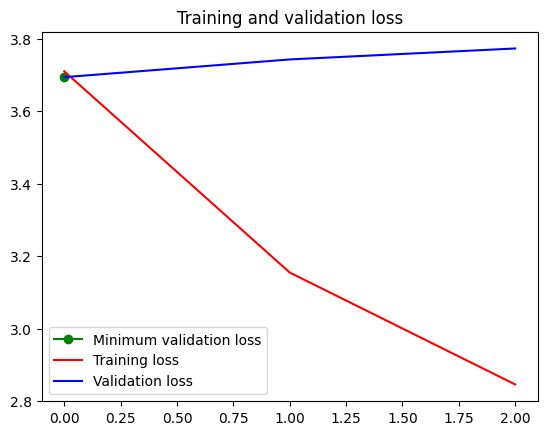

In [18]:
plot_training_history(history)

Preprocess reviews

In [19]:
#load the preprocessed reviews BUT!! We've pretrained the network on the same ones, it's an error
# maybe we don't need the preprocessing or we can skip the first 1000 reviews

cleaned_reviews = read_list_from_file(filename_review_list)
print(cleaned_reviews[0])

work perfect plug laptop tv lines sound interference definitely buy


In [20]:
len(cleaned_reviews)

1001

In [21]:
reviews_list_preprocessed = read_list_from_file(filename_review_list)
batches = get_batches(reviews_list_preprocessed, True)

Input 1 created with a length of 978 tokens.
Number of reviews processed: 43
Input 2 created with a length of 992 tokens.
Number of reviews processed: 80
Input 3 created with a length of 605 tokens.
Number of reviews processed: 99


In [22]:
summaries_first_stage = []
for input in batches:
  inputs  = tokenizer.encode(input, return_tensors='tf', truncation=True, max_length=1024)
  output = model.generate(inputs, max_length=100)
  decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
  # print(decoded_output)
  summaries_first_stage.append(nltk.sent_tokenize(decoded_output.strip())[0])

In [23]:
summaries_first_stage

['Great!', 'Great!', 'Basic HDMI cable']

In [24]:
batches[0]

"summarize:work perfect plug laptop tv lines sound interference definitely buy . clarity amazing connected cable computer tv even print ont comp good way better tv . say works ordered one ps3 problems expensive cable bought years ago screen flickering time n't spend money get cable . best thing could 've ever purchased save much money month see need directv love apple tv j plan buying one must apple tv great price . two complaints first cable quite thick difficult straighten coils secondly plastic plug surrounding hdmi connector thick would plug tv plastic contacted tvs back panel less half way inserted issue would give cable five stars tcl led tvs hdmi receptacles left side screen solved problem using 270 degree hdmi adapter asin b004pw3dks cable matters gold plated hdmi male hdmi female 270 degree adapter adapter thin enough plugs fully hides cable behind tv cleaner look upconverter dvd player combined cable adapter great picture sound quality . great product mistakenly purchased swi

In [25]:
#TODO rifare preprocessing ai testi

In [26]:
#Arrivati a questo punto possiamo avere già un'idea di cosa gli utenti pensano:
#Provare un secondo stage, ma non essendoci tanti dati utilizzerà un approccio estrattivo
#Andare avanti con l'analisi dei sentimenti, basandoci sui riassunti.

#Primo approccio (quello di sopra) riassunto di riassunti, tenendone in conto il maggior numero, 10 secondi per tutto

#Secondo approccio: (quello di giù (di Matteo?) riassunto di ogni testo e concatenazione di ogni riassunto, risulta essere lento)

In [27]:
input = "summarize: "
count = 0
checkpoint = 0
batches_second_stage = []
i = 0
for i in range(0,len(summaries_first_stage)):
  if count + len(summaries_first_stage[i].split(" ")) < 1024:
    #print(cleaned_reviews[i])
    input = input + summaries_first_stage[i] + " . "
    #print(input)
    count = count + len(summaries_first_stage[i].split(" "))
  else:
    batches_second_stage.append(input)
    print('Input {} created with a length of {} tokens.'.format(len(batches_second_stage), count))
    print("Number of reviews processed: {}".format(i))
    input = "summarize: " + summaries_first_stage[i] + " . "
    count = len(summaries_first_stage[i].split(" "))

if(count != 0):
  batches_second_stage.append(input)
  print('Input {} created with a length of {} tokens.'.format(len(batches_second_stage), count))
  print("Number of reviews processed: {}".format(i))

print(batches_second_stage)

Input 1 created with a length of 5 tokens.
Number of reviews processed: 2
['summarize: Great! . Great! . Basic HDMI cable . ']


In [28]:
summaries_second_stage = []
for input in batches_second_stage:
  inputs  = tokenizer.encode(input, return_tensors='tf', truncation=True, max_length=1024)
  output = model.generate(inputs, max_length=100)
  decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
  summaries_second_stage.append(nltk.sent_tokenize(decoded_output.strip())[0])

In [29]:
summaries_second_stage

['Basic HDMI cable']

In [30]:
device = cuda.get_current_device()
device.reset()